First of all, you have to import the library:

In [1]:
import BITS

Instead, you can load some specific funcitons/classes you want to use:

In [3]:
from BITS.utils import run_command

Or you can load a single whole submodule by:

In [3]:
from BITS import seq

We offer the following submodules for now:

* `utils`
* `seq`
* `run`
* `plot`
* (`sge_nize` and `slurm_nize` only from shell, which actually just calls a function of the same name in `utils`)

Below are detailed descriptions of the functions and classes of the submodules.

## BITS.utils

You can save a pickle object easily by:

In [26]:
sample_obj = (1, 4, 9)
BITS.utils.save_pickle(sample_obj, "sample.pkl")

And load a pickle object by:

In [28]:
BITS.utils.load_pickle("sample.pkl")

(1, 4, 9)

You can execute a shell command easily by:

In [33]:
BITS.utils.run_command("echo something")

'something\n'

Note that the return value of `run_command()` is a single string of the standard output.

`print_log()` is a simple decorator to write a log message when a function starts and ends. This requires `logzero` python module to output log messages. For example you can use it as:

In [44]:
@BITS.utils.print_log("Awesome function")
def do_something(arg, **other_args):
    print("Doing something")
    return

In [45]:
do_something(1, additional=2)

[I 190214 14:43:46 utils:46] Starting Awesome function (args=(1,), kwds={'additional': 2})
[I 190214 14:43:46 utils:48] Finished Awesome function


Doing something


You can add headers for a job scheduler such as SGE and SLURM to a shell script given as a string by:

In [46]:
script = "echo something"
BITS.utils.sge_nize(script)

'#!/bin/bash\n#$ -N run_script\n#$ -o sge.log\n#$ -j y\n#$ -S /bin/bash\n#$ -cwd\n#$ -V\n#$ -pe smp 1\n#$ -sync y\n\necho something\n'

In [47]:
script = "echo something"
BITS.utils.slurm_nize(script)

'#!/bin/bash\n#SBATCH -J run_script\n#SBATCH -o sbatch_stdout\n#SBATCH -e sbatch_stderr\n#SBATCH -n 1\n#SBATCH -N 1\n#SBATCH -c 1\n#SBATCH -t 24:00:00\n#SBATCH --mem-per-cpu=1024\n#SBATCH --partition=batch\n#SBATCH --wait\n\necho something\n'

You can specify some options to change the parameters (see the fucntions with `?` in Jupyter Notebook).

You can create a non-daemonic `Pool` object of the `multiprocessing` mudule using `NoDaemonPool`. A non-daemonic process can have child processes, although the original (daemonic) process cannot. You can use it completely same as original `Pool`:

In [49]:
def return_itself(arg):
    return arg

In [50]:
n_core = 2   # Number of cores to be used for the parallel computation
with BITS.utils.NoDaemonPool(n_core) as pool:
    for ret in pool.map(return_itself, range(5)):
        print(ret)

0
1
2
3
4


Below are utility functions for the `pyinterval` module:

In [2]:
from interval import interval

In [3]:
BITS.utils.interval_len(interval([1, 2], [4, 5]))

4.0

This returns **the number of integers** contained in the given interval.

In [14]:
BITS.utils.subtract_interval(interval([1, 5], [8, 10]), interval([2, 3], [5, 9]))

interval([1.0], [4.0, 5.0], [10.0])

And this calculates the subtraction of the second interval from the first interval **as integer intervals**.

## BITS.seq

Suppose you have a (ill-formatted) fasta file like:

In [4]:
!(cat sample.fasta)

>sample1
AAAAAAAAAAAAAAAAAAAAAAAAAAAA
>sample2
CCCCCCCCCCCCCCCCCCCCCC
GGGGGGGGG
TTTTTTTTTTTTTTTTTTTTTTTTT
>sample3
ACTACTAGCTGATCG

Then you can load this as a dictionary by:

In [7]:
seqs = BITS.seq.load_fasta("sample.fasta")
seqs

{'sample1': 'AAAAAAAAAAAAAAAAAAAAAAAAAAAA',
 'sample2': 'CCCCCCCCCCCCCCCCCCCCCCGGGGGGGGGTTTTTTTTTTTTTTTTTTTTTTTTT',
 'sample3': 'ACTACTAGCTGATCG'}

This operation above is internally using the BioPython's function, so any type of fasta can be loaded as you expect.

You can split a string into a list of fixed-length strings by:

In [12]:
seq = seqs['sample2']   # sequence to be splitted
BITS.seq.single_to_multi(seq, width=10)   # <width> is the (maximum) length of each string

['CCCCCCCCCC',
 'CCCCCCCCCC',
 'CCGGGGGGGG',
 'GTTTTTTTTT',
 'TTTTTTTTTT',
 'TTTTTT']

You can save a fasta by:

In [13]:
BITS.seq.save_fasta(seqs, "sample.out.fasta")

In [14]:
!(cat sample.out.fasta)

>sample1
AAAAAAAAAAAAAAAAAAAAAAAAAAAA
>sample2
CCCCCCCCCCCCCCCCCCCCCCGGGGGGGGGTTTTTTTTTTTTTTTTTTTTTTTTT
>sample3
ACTACTAGCTGATCG


Be careful that the input `seqs` must be a dictionary like above. You can specify the maximum file width by `out_type="multi"` (and `width=XX`) option. The function with this option internally calls `single_to_multi()` just above for each sequence. Also you can set `sort=True` option and then the sequences will be sorted according to their names.

You can take reverse complement of a sequence by:

In [17]:
print(seq)
BITS.seq.revcomp(seq)

CCCCCCCCCCCCCCCCCCCCCCGGGGGGGGGTTTTTTTTTTTTTTTTTTTTTTTTT


'AAAAAAAAAAAAAAAAAAAAAAAAACCCCCCCCCGGGGGGGGGGGGGGGGGGGGGG'

You can plot a dot plot between two sequences with a class `DotPlot`. To use this, [Gepard](http://cube.univie.ac.at/gepard) must be installed in advance. First you have to specify some names like:

In [19]:
out_dir = "tmp"   # Name of an arbitray directory for temporary storage of Gepard input and output. Change as you like.
gepard_root = "/path/to/gepard/"   # Change to the directory in which you installed Gepard.
gepard_jar = gepard_root + "dist/Gepard-1.40.jar"
gepard_mat = gepard_root + "resources/matrices/edna.mat"
gepard_command = f"java -cp {gepard_jar} org.gepard.client.cmdline.CommandLine -matrix {gepard_mat}"

And make an instance of `DotPlot` class using these variables:

In [20]:
d = BITS.seq.DotPlot(out_dir, gepard_command)

Then you can plot a dot plot of any two strings by (though the example below is very nonsense due to the sequence contents):

AAAAAAAAAAAAAAAAAAAAAAAAAAAA vs CCCCCCCCCCCCCCCCCCCCCCGGGGGGGGGTTTTTTTTTTTTTTTTTTTTTTTTT


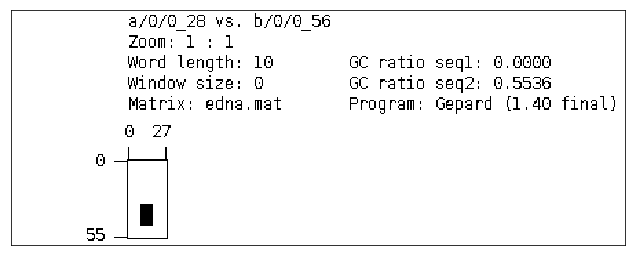

In [25]:
seq_a = seqs["sample1"]
seq_b = seqs["sample2"]
print(f"{seq_a} vs {seq_b}")
d.plot(seq_a, seq_b)

## BITS.run

Although it is still in development, we offer a class for CIGAR string manipulations:

In [25]:
cigar = BITS.run.Cigar("3D10=1I5=1X4=")
cigar

CIGAR string will be stored as an instance variable:

In [26]:
cigar.string

'3D10=1I5=1X4='

You can iterate CIGAR by:

In [27]:
for c in cigar.iter():
    print(c)

(3, 'D')
(10, '=')
(1, 'I')
(5, '=')
(1, 'X')
(4, '=')


which returns you tuples for each segment of same operations. Actually `iter()` is a generator and thus you can instead obtain a list of the tuples by:

In [28]:
list(cigar.iter())

[(3, 'D'), (10, '='), (1, 'I'), (5, '='), (1, 'X'), (4, '=')]

You can get alignment length (= the number of all operations in the CIGAR) by:

In [29]:
cigar.alignment_len

24

You can reverse CIGAR, which is useful for reverse complement of the same sequence, by:

In [30]:
cigar.reversed()

'4=1X5=1I10=3D'

You can "flatten" CIGAR as follows. Sometimes this form is much easier to handle:

In [31]:
cigar.flatten().string

'DDD==========I=====X===='

You can calculate alignment between two strings using `edlib` library:

In [40]:
alignment = BITS.run.run_edlib("ACGTTTAGAT", "AGGTTCGAGAT", "global")
alignment

The function `run_edlib()` supports several options such as

* `mode=["global", "glocal", "local"]`: alignment type
* `only_diff=True`: returns only %difference as a float value
* `rc=True`: consider also reverse complement of the target sequence and returns better alignment among forward alignment and reverse complement alignment
* `cyclic`: perform cyclic alignment between the two sequences
* `return_seq=True` (for "glocal" mode): add an instance variable `seq` in the returned `Align` object, which is a substring of the target sequence aligned to the query.

For other options and detailed description, see the docstring of the function.

The return value of `run_edlib()` is a class `Align`, which is also defined in `BITS.run`. You can confirm the attributes in the class instance object by:

In [41]:
alignment.__dict__

{'start': 0,
 'end': 11,
 'edit_dist': 3,
 'cigar': <BITS.run.Cigar at 0x7f8547614748>,
 'length': 11,
 'diff': 0.2727272727272727,
 'strand': 0}

or briefly with CIGAR string by:

In [37]:
alignment.show(show_cigar=True)

[I 190214 17:07:26 run:109] target[0:11] (11 bp, 0.273 diff)
[I 190214 17:07:26 run:111] 1=1X3=1X1D4=


## BITS.plot

Below is a function to easily make a line object which is an instance for the `shape` object used in `go.Layout` of `Plotly`:

In [42]:
BITS.plot.make_line(0, 0, 1, 1)

{'type': 'line',
 'xref': 'x',
 'yref': 'y',
 'x0': 0,
 'y0': 0,
 'x1': 1,
 'y1': 1,
 'line': {'color': 'black', 'width': 1},
 'layer': 'below'}

If you just want to draw a simple scatter plot with two list-like objects with `Plotly`, you can do it as follows:

In [47]:
# necessary for showing plots in Jupyter Notebook
import plotly.offline as py
py.init_notebook_mode(connected=True)

In [52]:
data_x = list(range(5))
data_y = list(range(5, 10))
text = list(range(10, 15))   # texts shown on the data points when hovering over the points; this is not mandatory
BITS.plot.plot_scatter(data_x, data_y, text, width=500, height=500)

## sge_nize and slurm_nize from shell

You can do a similar thing as `BITS.utils.[sge|slurm]_nize()` from command-line as follows:

In [59]:
!(cat sample.sh)

#!/bin/bash
echo something


In [57]:
# Be careful that python executable called by Jupyter can be different from the one you expect
!(/your/path/to/python3 -m BITS.sge_nize sample.sh)

In [60]:
!(cat sample.sh.sge)

#!/bin/bash
#$ -N run_script
#$ -o sge.log
#$ -j y
#$ -S /bin/bash
#$ -cwd
#$ -V
#$ -pe smp 1
#$ -sync y

bash sample.sh



Then you can run `sample.sh` with the job scheduler by `$ qsub sample.sh.sge`. Same holds for SLURM.